Reference: https://python.langchain.com/docs/how_to/message_history/

In [1]:
# Step 1: Defining a State
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage

# Define a typed state
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]

/Users/kanavbansal/Developer/.env_jupyter/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Step 2: Defining graph nodes
from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

# Set the OpenAI Key and initialize a ChatModel
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-4o")

def process(state: AgentState) -> AgentState:
    """This node will solve the request you input"""
    response = llm.invoke(state["messages"])

    state["messages"].append(AIMessage(content=response.content)) 
    print(f"\nAI: {response.content}")
    print("CURRENT STATE: ", state["messages"])

    return state

In [6]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("process", process)

graph.add_edge(START, "process")
graph.add_edge("process", END)

In [7]:
# Step 4: Compile the graph

agent = graph.compile()

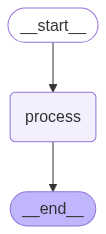

In [8]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    result = agent.invoke({"messages": conversation_history})
    conversation_history = result["messages"]
    user_input = input("Enter: ")

Enter:  hi, my name is ThatAIGuy.



AI: Hello, ThatAIGuy! How can I assist you today?
CURRENT STATE:  [HumanMessage(content='hi, my name is ThatAIGuy.', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello, ThatAIGuy! How can I assist you today?', additional_kwargs={}, response_metadata={})]


Enter:  can you tell me a joke?



AI: Sure! Why don't scientists trust atoms?

Because they make up everything!
CURRENT STATE:  [HumanMessage(content='hi, my name is ThatAIGuy.', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello, ThatAIGuy! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='can you tell me a joke?', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure! Why don't scientists trust atoms?\n\nBecause they make up everything!", additional_kwargs={}, response_metadata={})]


Enter:  do you remember my name?



AI: Yes, you mentioned that your name is ThatAIGuy.
CURRENT STATE:  [HumanMessage(content='hi, my name is ThatAIGuy.', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello, ThatAIGuy! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='can you tell me a joke?', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure! Why don't scientists trust atoms?\n\nBecause they make up everything!", additional_kwargs={}, response_metadata={}), HumanMessage(content='do you remember my name?', additional_kwargs={}, response_metadata={}), AIMessage(content='Yes, you mentioned that your name is ThatAIGuy.', additional_kwargs={}, response_metadata={})]


Enter:  exit


## **Introduction to LangGraph for Memory**

As of the v0.3 release, LangChain recommends that users take advantage of LangGraph persistence to incorporate memory into new LangChain applications.

If your code is already relying on `RunnableWithMessageHistory` or `BaseChatMessageHistory`, you do not need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses `RunnableWithMessageHistory` will continue to work as expected.

In this guide we cover two types of memory:
1. Short Term Memory (aka Thread Scope Memory)
2. Long Term Memory


### **Short-term memory**

Short-term memory lets your application remember previous interactions within a single thread or conversation. A thread organizes multiple interactions in a session, similar to the way email groups messages in a single conversation.

LangGraph manages short-term memory as part of the agent's state, persisted via thread-scoped checkpoints. This state can normally **include the conversation history along with other stateful data, such as uploaded files, retrieved documents, or generated artifacts**. By storing these in the graph's state, the bot can access the full context for a given conversation while maintaining separation between different threads.

When creating any LangGraph graph, you can set it up to persist its state by adding a checkpointer when compiling the graph:

```python
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph.compile(checkpointer=memory)
```

#### **Steps**
1. Define a graph - We will be using a single-node graph that calls a chat model.
2. Add persistence - To add in persistence, we need to pass in a Checkpointer when compiling the graph.


### **Long-term memory**

Since conversation history is the most common form of representing short-term memory, in the next section, we will cover techniques for managing conversation history when the list of messages becomes long. If you want to stick to the high-level concepts, continue on to the long-term memory section.


In [1]:
from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

# Set the OpenAI Key and initialize a ChatModel
chat_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

/Users/kanavbansal/Developer/.env_langchain/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Adding MessageState to Chat Model**  

Chat models accept a list of messages as input and output a message. 

**LangGraph** includes a built-in MessagesState that we can use for this purpose.

Below we:
1. Define the graph state to be a list of messages;
2. Add a single node to the graph that calls a chat model;
3. Compile the graph with an in-memory checkpointer to store messages between runs.

In [2]:
from langchain_core.messages import SystemMessage
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the function that calls the model

# Define the function that calls the model
def call_model(state: MessagesState):
    system_prompt = (
        "You are a helpful assistant. "
        "Answer all questions to the best of your ability."
    )
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = chat_model.invoke(messages)
    return {"messages": response}


# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

print(workflow)

In [3]:
from langgraph.checkpoint.memory import MemorySaver

# Adding memory is straight forward in langgraph!
memory = MemorySaver()

graph = workflow.compile(
    checkpointer=memory
)

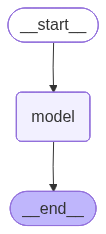

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
import uuid

# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
# This enables a single application to manage conversations among multiple users.
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

print(config)

{'configurable': {'thread_id': UUID('e1406dce-59e9-41ed-bd01-97f1d83a4e7e')}}


## **.invoke()**

In [6]:
from langchain_core.messages import HumanMessage

input_messages = HumanMessage(content="Hi! I'm Kanav")

response = graph.invoke({"messages": input_messages}, config)

In [7]:
print(response)

{'messages': [HumanMessage(content="Hi! I'm Kanav", additional_kwargs={}, response_metadata={}, id='163402f6-4a5f-4ea0-a6ba-809c6250e64f'), AIMessage(content='Hello Kanav! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 33, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CkQcbs0PiS1QH2OxKl6c4w9YFlvbQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--1260a49b-214a-42b3-9d4a-88aae0323864-0', usage_metadata={'input_tokens': 33, 'output_tokens': 11, 'total_tokens': 44, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [8]:
# output contains all messages in state

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi! I'm Kanav
================================== Ai Message ==================================

Hello Kanav! How can I assist you today?


## **.stream()**

In [9]:
from langchain_core.messages import HumanMessage

input_message = HumanMessage(content="What can you do for me?")

for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What can you do for me?
================================== Ai Message ==================================

I can help answer questions, provide information on a wide range of topics, assist with tasks or reminders, offer suggestions, or simply have a conversation with you. Feel free to let me know how I can assist you today!


In [10]:
# Here, let's confirm that the AI remembers our name!
input_message = HumanMessage(content="what is my name?")

for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Kanav.
